In [114]:
#importing libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


In [115]:
# AMAZON stocks
stock_ticker="AMZN"

# data by yahoo finance
stock = yf.download(stock_ticker, start="2013-06-01", end="2023-06-01")

print(stock)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2013-06-03   13.448000   13.455500   13.147500   13.344000   13.344000  \
2013-06-04   13.350000   13.444000   13.151000   13.285000   13.285000   
2013-06-05   13.290500   13.583000   13.251000   13.358500   13.358500   
2013-06-06   13.387500   13.525000   13.210500   13.391500   13.391500   
2013-06-07   13.487000   14.005000   13.456500   13.843500   13.843500   
...                ...         ...         ...         ...         ...   
2023-05-24  115.349998  117.339996  115.019997  116.750000  116.750000   
2023-05-25  116.629997  116.870003  114.309998  115.000000  115.000000   
2023-05-26  116.040001  121.500000  116.019997  120.110001  120.110001   
2023-05-30  122.370003  122.919998  119.860001  121.660004  121.660004   
2023-05-31  121.449997  122.040001  119.169

In [116]:
#Now we will calculate SMA and standard deviation to find lower and upper band 

stock['SMA'] = stock.Close.rolling(20).mean()

stock_prices = (stock.High + stock.Close + stock.Low)/3
StandardDeviation = stock_prices.rolling(20).std()
stock['upper_band'] = stock['SMA'] + (2 * StandardDeviation)
stock['lower_band'] = stock['SMA'] - (2 * StandardDeviation)
stock['Signal'] = 'Hold'
print(stock)

                  Open        High         Low       Close   Adj Close   
Date                                                                     
2013-06-03   13.448000   13.455500   13.147500   13.344000   13.344000  \
2013-06-04   13.350000   13.444000   13.151000   13.285000   13.285000   
2013-06-05   13.290500   13.583000   13.251000   13.358500   13.358500   
2013-06-06   13.387500   13.525000   13.210500   13.391500   13.391500   
2013-06-07   13.487000   14.005000   13.456500   13.843500   13.843500   
...                ...         ...         ...         ...         ...   
2023-05-24  115.349998  117.339996  115.019997  116.750000  116.750000   
2023-05-25  116.629997  116.870003  114.309998  115.000000  115.000000   
2023-05-26  116.040001  121.500000  116.019997  120.110001  120.110001   
2023-05-30  122.370003  122.919998  119.860001  121.660004  121.660004   
2023-05-31  121.449997  122.040001  119.169998  120.580002  120.580002   

              Volume         SMA  upp

In [117]:
#Buy and sell signals

stock['Buy'] = np.where(stock['lower_band'] > stock['Close'] ,True,False)
stock['Sell'] = np.where(stock['upper_band'] < stock['Close'] ,True,False)

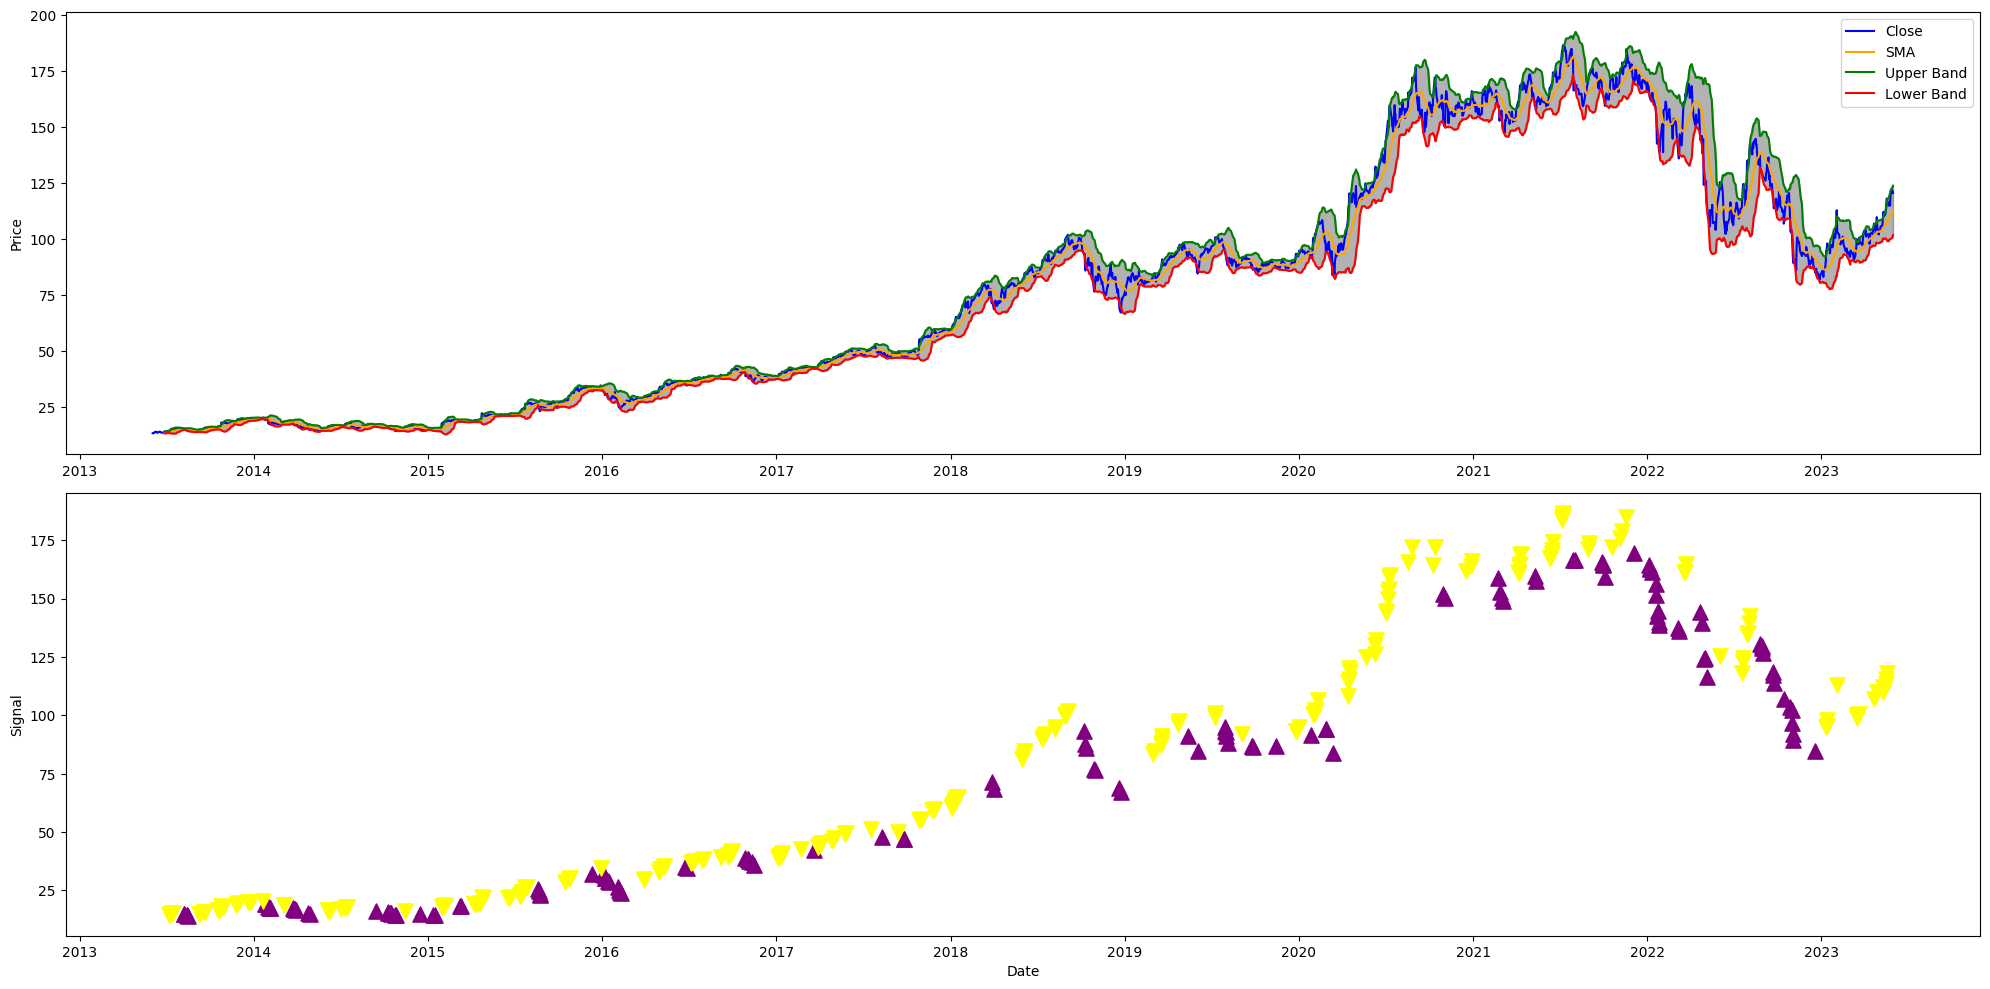

In [118]:
# figure and subplots
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

ax1.plot(stock['Close'], color='blue')
ax1.plot(stock['SMA'], color='orange')
ax1.plot(stock['upper_band'], color='green')
ax1.plot(stock['lower_band'], color='red')
ax1.fill_between(stock.index, stock['upper_band'], stock['lower_band'], color='black', alpha=0.3)
ax1.legend(['Close', 'SMA', 'Upper Band', 'Lower Band'])


# buy and sell signals
ax2.scatter(stock.index[stock.Buy], stock.loc[stock.Buy, 'Close'], marker='^', color='purple', s=120)
ax2.scatter(stock.index[stock.Sell], stock.loc[stock.Sell, 'Close'], marker='v', color='yellow', s=120)

ax1.set_ylabel('Price')
ax2.set_ylabel('Signal')
ax2.set_xlabel('Date')
fig.tight_layout()

plt.show()


In [119]:
# Percentage Change in Closing Price per day
stock['per_day_return'] =(stock['Close']-stock['Open'])/stock['Open']

# Positive/Negative Returns based on Buy/Sell Signals
stock['loc'] = np.where(stock['Buy'] > stock['Sell'], stock['per_day_return'], -stock['per_day_return'])

# Cumulative returns
stock_bb_cumulative_return= (stock['loc'] + 1).product() -1

# Rolling maximum
stock['cumulative_rolling_max'] = (stock['loc'] + 1).cumprod()-1

# Drawdown
drawdown = stock_bb_cumulative_return - stock['cumulative_rolling_max']

# Max Drawdown
stock_bb_Max_drawdown = np.min(drawdown)



In [120]:
# Now we will calculate annual returns
stock_annual_returns= stock['loc'].mean()*252

# Risk free rate
stock_risk_free_rate = 0.02

# Annual SD
stock_annual_std_dev = stock['loc'].std()*np.sqrt(252)

# Sharpe Ratio
stock_bb_Sharpe_ratio=(stock_annual_returns-stock_risk_free_rate) / stock_annual_std_dev

In [121]:
print("Max Drawdown:",stock_bb_Max_drawdown)
print("Cumulative Return:",stock_bb_cumulative_return)
print("Sharpe Ratio:",stock_bb_Sharpe_ratio)

Max Drawdown: -1.0034182244929293
Cumulative Return: -0.9907781179189767
Sharpe Ratio: -1.8172499429253743


In [122]:
def apply_bollinger_strategy(prices, upper_band, lower_band):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = 0

    for i in range(len(prices)):
        if prices[i] < lower_band[i]:
            if position != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                position = 1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif prices[i] > upper_band[i]:
            if position != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                position = -1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    return buy_price, sell_price, bb_signal
buy_price, sell_price, bb_signal = apply_bollinger_strategy(stock['Close'],stock['upper_band'], stock['lower_band'])

position = []
if bb_signal[0] == 1:
    position.append(1)
else:
    position.append(0)

for i in range(1, len(stock['Close'])):
    if bb_signal[i] == 1:
        position.append(1)
    elif bb_signal[i] == -1:
        position.append(0)
    else:
        position.append(position[i-1])

bb_signal = pd.DataFrame(bb_signal).rename(columns={0: 'bb_signal'}).set_index(stock.index)
position = pd.DataFrame(position).rename(columns={0: 'bb_position'}).set_index(stock.index)

frames = [stock['Close'],stock['upper_band'],stock['lower_band'], bb_signal, position]
strategy = pd.concat(frames, join='inner', axis=1)
print(strategy)

                 Close  upper_band  lower_band  bb_signal  bb_position
Date                                                                  
2013-06-03   13.344000         NaN         NaN          0            0
2013-06-04   13.285000         NaN         NaN          0            0
2013-06-05   13.358500         NaN         NaN          0            0
2013-06-06   13.391500         NaN         NaN          0            0
2013-06-07   13.843500         NaN         NaN          0            0
...                ...         ...         ...        ...          ...
2023-05-24  116.750000  120.099980   99.959021          0            0
2023-05-25  115.000000  120.633155   99.943846          0            0
2023-05-26  120.110001  121.922637  100.120365          0            0
2023-05-30  121.660004  123.203993  100.800008          0            0
2023-05-31  120.580002  123.863854  101.835148          0            0

[2517 rows x 5 columns]


In [123]:
stock_ret = np.diff(stock['Close'])
bb_strategy_ret = []

for i in range(len(stock_ret)):
    try:
        returns = stock_ret[i] * strategy['bb_position'][i]
        bb_strategy_ret.append(returns)
    except:
        pass

In [124]:
import math


investment_value = 10000
number_of_stocks = math.floor(investment_value / stock['Close'][0])
bb_investment_ret = []

for i in range(len(bb_strategy_ret)):
    returns = number_of_stocks * bb_strategy_ret[i]
    bb_investment_ret.append(returns)

total_investment_ret = round(sum(bb_investment_ret), 2)
profit_percentage = math.floor((total_investment_ret / investment_value) * 100)

print('By Bollinger Bands Profit by investing 10k in Amazon : {}'.format(total_investment_ret))
print('Profit percentage : {}%'.format(profit_percentage))

By Bollinger Bands Profit by investing 10k in Amazon : 17168.96
Profit percentage : 171%


In [125]:
def get_ad_line(high, low, close, volume):
    ad_line = ((close - low) - (high - close)) / (high - low) * volume
    ad_line = ad_line.cumsum()
    ad_line_df = pd.DataFrame(ad_line, columns=['ad_line']).set_index(close.index)
    ad_line_df = ad_line_df.dropna()
    return ad_line_df

stock['AD_Line'] = get_ad_line(stock['High'], stock['Low'], stock['Close'], stock['Volume'])
stock = stock.dropna()
print(stock)

                  Open        High         Low       Close   Adj Close   
Date                                                                     
2013-06-28   13.809500   13.991500   13.809500   13.884500   13.884500  \
2013-07-01   13.950000   14.164500   13.858000   14.105000   14.105000   
2013-07-02   14.052000   14.329000   14.029500   14.186500   14.186500   
2013-07-03   14.100000   14.270000   14.100000   14.201500   14.201500   
2013-07-05   14.250000   14.319000   14.103500   14.294000   14.294000   
...                ...         ...         ...         ...         ...   
2023-05-24  115.349998  117.339996  115.019997  116.750000  116.750000   
2023-05-25  116.629997  116.870003  114.309998  115.000000  115.000000   
2023-05-26  116.040001  121.500000  116.019997  120.110001  120.110001   
2023-05-30  122.370003  122.919998  119.860001  121.660004  121.660004   
2023-05-31  121.449997  122.040001  119.169998  120.580002  120.580002   

              Volume         SMA  upp

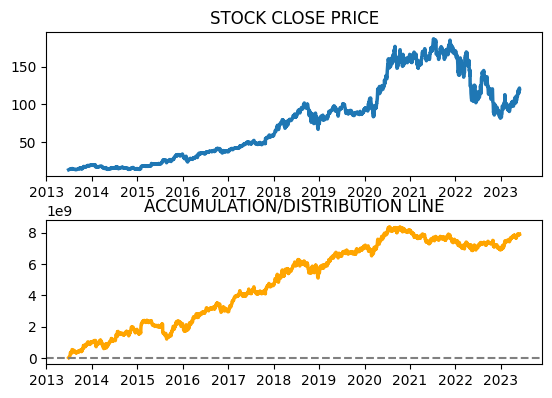

In [126]:
ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)

ax1.plot(stock['Close'], linewidth=2.5)
ax1.set_title('STOCK CLOSE PRICE')

ax2.plot(stock['AD_Line'], color='orange', linewidth=2.5)
ax2.axhline(0, linestyle='--', linewidth=1.5, color='grey')
ax2.set_title('ACCUMULATION/DISTRIBUTION LINE')

plt.show()

In [127]:
def apply_ad_line_strategy(prices, ad_line):    
    buy_price = []
    sell_price = []
    ad_line_signal = []
    signal = 0

    for i in range(len(ad_line)):
        if ad_line[i-1] > 0 and ad_line[i] < 0:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                ad_line_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ad_line_signal.append(0)
        elif ad_line[i-1] < 0 and ad_line[i] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                ad_line_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ad_line_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ad_line_signal.append(0)
    return buy_price, sell_price, ad_line_signal

buy_price, sell_price, ad_line_signal = apply_ad_line_strategy(stock['Close'], stock['AD_Line'])


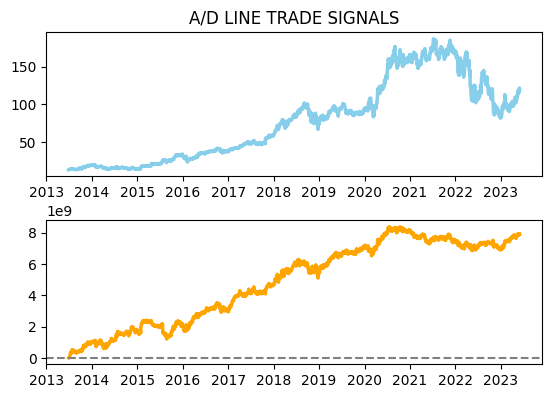

In [128]:
ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(stock['Close'], linewidth=2.5, color='skyblue', label='STOCK')
ax1.plot(stock.index, buy_price, marker='^', markersize=10, color='green', label='BUY SIGNAL')
ax1.plot(stock.index, sell_price, marker='v', markersize=10, color='r', label='SELL SIGNAL')
ax1.set_title('A/D LINE TRADE SIGNALS')
ax2.plot(stock['AD_Line'], color='orange', linewidth=2.5)
ax2.axhline(0, linestyle='--', linewidth=1.5, color='grey')
plt.show()

In [129]:
position = []
for i in range(len(ad_line_signal)):
    if ad_line_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(stock['Close'])):
    if ad_line_signal[i] == 1:
        position[i] = 1
    elif ad_line_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

adi = stock['AD_Line']
close_price = stock['Close']
ad_line_signal = pd.DataFrame(ad_line_signal, columns=['AD_Line_Signal']).set_index(stock.index)
position = pd.DataFrame(position, columns=['Position']).set_index(stock.index)

frames = [close_price, adi, ad_line_signal, position]
strategy = pd.concat(frames, join='inner', axis=1)

strategy.head()



,Close,AD_Line,AD_Line_Signal,Position
Date,,,,
2013-06-28,13.8845,4.226437e+07,0,1
2013-07-01,14.1050,7.760101e+07,0,1
2013-07-02,14.1865,8.073621e+07,0,1
2013-07-03,14.2015,8.606652e+07,0,1
2013-07-05,14.2940,1.165613e+08,0,1


In [130]:
import math

stock_ret = pd.DataFrame(list(np.diff(stock['Close']))).rename(columns={0: 'returns'})

ad_strategy_ret = []

for i in range(len(stock_ret)):
    returns = stock_ret['returns'][i] * strategy['Position'][i]
    ad_strategy_ret.append(returns)

ad_strategy_ret_df = pd.DataFrame(ad_strategy_ret).rename(columns={0: 'investment_returns'})

investment_value = 10000
number_of_stocks = math.floor(investment_value / stock['Close'][-1])

ad_investment_ret = []

for i in range(len(ad_strategy_ret_df['investment_returns'])):
    returns = number_of_stocks * ad_strategy_ret_df['investment_returns'][i]
    ad_investment_ret.append(returns)

ad_investment_ret_df = pd.DataFrame(ad_investment_ret)

total_investment_ret = round(sum(ad_investment_ret_df[0]), 2)
profit_percentage = math.floor((total_investment_ret / investment_value) * 100)

print('By AD strategy profit by investing $10k in Amazon : {}'.format(total_investment_ret))
print('Profit percentage of the AD strategy: {}%'.format(profit_percentage))

By AD strategy profit by investing $10k in Amazon : 8749.03
Profit percentage of the AD strategy: 87%


In [131]:
# Bollinger Bands Strategy
def apply_bollinger_strategy(prices, upper_band, lower_band):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = 0

    for i in range(len(prices)):
        if prices[i] < lower_band[i]:
            if position != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                position = 1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif prices[i] > upper_band[i]:
            if position != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                position = -1
                bb_signal.append(position)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)

    return buy_price, sell_price, bb_signal

# AD Line Strategy
def apply_ad_line_strategy(prices, ad_line):
    buy_price = []
    sell_price = []
    ad_line_signal = []
    signal = 0

    for i in range(len(ad_line)):
        if ad_line[i-1] > 0 and ad_line[i] < 0:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                ad_line_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ad_line_signal.append(0)
        elif ad_line[i-1] < 0 and ad_line[i] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                ad_line_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ad_line_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ad_line_signal.append(0)
    
    return buy_price, sell_price, ad_line_signal

# Apply Bollinger Bands strategy
buy_price_bb, sell_price_bb, bb_signal = apply_bollinger_strategy(stock['Close'], stock['upper_band'], stock['lower_band'])

# Apply AD Line strategy
buy_price_ad, sell_price_ad, ad_line_signal = apply_ad_line_strategy(stock['Close'], stock['AD_Line'])

# Combine the signals
combined_signals = []
for i in range(len(stock)):
    if bb_signal[i] == 1 or ad_line_signal[i] == 1:
        combined_signals.append('BUY')
    elif bb_signal[i] == -1 or ad_line_signal[i] == -1:
        combined_signals.append('SELL')
    else:
        combined_signals.append('NONE')

# Calculate returns for combined strategy
combined_investment = 10000
combined_number_of_stocks = math.floor(combined_investment / stock['Close'][0])
combined_in_hand = combined_investment - combined_number_of_stocks * stock['Close'][0]

for i in range(len(combined_signals)):
    if combined_signals[i] == 'BUY':
        temp = combined_in_hand // stock['Close'][i]
        combined_in_hand -= temp * stock['Close'][i]
        combined_number_of_stocks += temp
    elif combined_signals[i] == 'SELL':
        combined_in_hand += combined_number_of_stocks


In [132]:
combined_signals_df = pd.DataFrame(combined_signals, columns=['Signal']).set_index(stock.index)
combined_strategy = pd.concat([stock['Close'], combined_signals_df], axis=1)

combined_strategy['Position'] = np.where(combined_strategy['Signal'] == 'BUY', 1, 0)
combined_strategy['Position'] = np.where(combined_strategy['Signal'] == 'SELL', -1, combined_strategy['Position'])
combined_strategy['Position'] = combined_strategy['Position'].ffill()

combined_strategy_ret = combined_strategy['Close'].pct_change() * combined_strategy['Position'].shift()
combined_strategy_ret = combined_strategy_ret.dropna()

combined_investment_ret = combined_strategy_ret * combined_number_of_stocks
total_combined_investment_ret = round(sum(combined_investment_ret), 2)
total_investment_value = combined_investment + combined_number_of_stocks * stock['Close'][-1]
profit_percentage_combined = math.floor((total_combined_investment_ret / total_investment_value) * 100)

print('By the combined Bollinger Bands and AD strategy profit by investing $10k in Amazon is: {}'.format(total_combined_investment_ret))
print('Profit percentage : {}%'.format(profit_percentage_combined))


By the combined Bollinger Bands and AD strategy profit by investing $10k in Amazon is: -94.18
Profit percentage : -1%
